# COMP47590: Advanced Machine Learning
## Assignment 1: RoboRacer

Autonomously driven vehicles have been long-promised , but are finally becoming a reality. This assignment will train a model to control a self-driving car. This starter notebook puts in place data loaders to use for this assignment.

- Student 1 Name: Scott Carey
- Student 1 Number: 23216726
- Student 2 Name: Christopher Kenny
- Student 2 Number: 19430456

### Import Packages

In [63]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import cuda


import os

import random 

import matplotlib.pyplot as plt

import wandb

from xy_dataset import XYDataset 
from xy_dataset import CombinedDataset

### Dataset Setup

Setup the dataset - using custom dataset opbject.

In [64]:
ROOT_DIR = './'
TASK = 'robo_racer_dev'

We specify the hyperparameteres to be used with our models here (Training Split Size, Batch Size, Learning Rate, Number of Epochs).

In [65]:
TRAINING_SPLIT_SIZE = 0.8
BATCH_SIZE = 28
LEARNING_RATE = 0.001
NUM_EPOCHS = 50


TRANSFORMS = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()
                                ])

dataset = XYDataset(ROOT_DIR + TASK, TRANSFORMS)

n_samples = len(dataset)

print("Dataset length: ", n_samples)

Dataset length:  1192


### Partition Dataset

Partition the datset into training and valudation partitons using PyTorch data loaders. 

In [40]:
n_train = int(n_samples*TRAINING_SPLIT_SIZE)
n_val = n_samples - n_train

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

print("Training dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(val_dataset))

# Create Train Dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Create Validation Dataloader
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Training dataset length:  953
Validation dataset length:  239


### Task 1: View Sample Images

Exam a selection of	sample images from	the	training and validation	
datasets sample	images.

We created a function that displays a grid of images from a PyTorch dataloader.

In [66]:
def show_images(dataloader, title):
    # We extract a batch of images and their corresponding labels from the dataloader. The labels are the XY coordinates of the best driving line.
    images, labels = next(iter(dataloader))

    # Three rows per grid
    nrow = 3

    # Randomly select 9 images in total to display based on their indicie
    random_indices = torch.randperm(images.size(0))[:9]
    images = images[random_indices]

    # Use torchvision make_grid function to arange our images
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)

    # To work with mathplotlib we transpose the grid
    grid_np = grid.numpy().transpose((1, 2, 0))

    # We create a mathplotlib gird
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

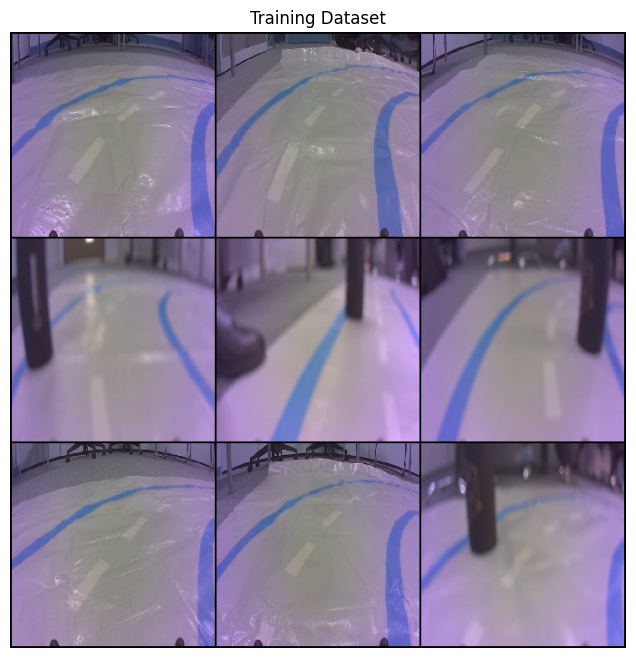

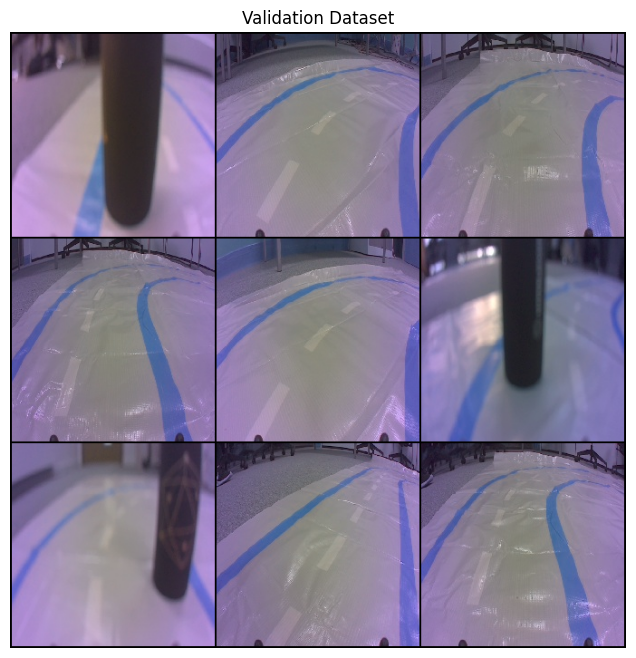

In [67]:
# Calling our function to display images from our train and validation dataset.
show_images(train_dataloader, "Training Dataset")
show_images(val_dataloader, "Validation Dataset")

### Task 2: Simple CNN

In [68]:
class CNN(nn.Module):

    # Defining the Constructor
    def __init__(self):
        super(CNN, self).__init__()

        # In the init function, we define the layers that will be used in our model

        # Here we Adjust input channels to account for RGB values (3)
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, stride=1, padding=1)

        # Apply max pooling with a kernel size of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # The second convolutional layer takes 32 input channels, and generates 64 outputs
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, padding=1)

        # Apply max pooling with a kernel size of 2
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Our input images will be resized to a smaller size after pooling operations.
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=128) 

        # Modify the output features of the final fully connected layer to 2 for (X, Y) coordinates
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        # In the forward function, pass the data through the layers defined in the init function

        # Use a ReLU activation function after convolution layer 1 and pooling layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)

        # We do the same for convolution layer 2 and pooling layer 2
        x = F.relu(self.pool2(self.conv2(x)))

        # Flatten the output of the second convolutional layer
        x = x.view(-1, 64 * 56 * 56) 
        # Feed to fully-connected layer to predict (X, Y) coordinates
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


We train and evaluate our model.

In [69]:

def train_model(model, train_dataloader, val_dataloader, num_epochs, learning_rate, runName):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)


    # Initialize Weights & Biases
    wandb.init(project="RoboRacer", name=runName)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            # Convert labels to float
            loss = criterion(outputs, labels.float())  
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
            #Log training loss to Weights & Biases
            wandb.log({"Training Loss": loss.item()})

        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, labels in val_dataloader:
                outputs = model(images)
                val_loss += criterion(outputs, labels.float()).item()

            # Calculate average validation loss
            val_loss /= len(val_dataloader)

            # Log validation loss to Weights & Biases
            wandb.log({"Validation Loss": val_loss})
        

    wandb.finish()  # Finish logging


Call our training and evaluation function

In [45]:
model = CNN()
print(model)

train_model(model, train_dataloader, val_dataloader, NUM_EPOCHS, LEARNING_RATE, "Simple CNN")

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Training Loss,█▆▄▇▄▃▃▄▄▃▂▃▃▁▂▄▃▂▂▂▂▂▂▁▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂
Validation Loss,█▅▅▄▃▃▃▃▁▁▂▁▂▁▁▆▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▁▂▂▁▂▂
Training Loss,0.0078
Validation Loss,0.02467


Epoch [1/50], Loss: 230.4504
Epoch [2/50], Loss: 1.9210
Epoch [3/50], Loss: 1.8419
Epoch [4/50], Loss: 1.7370
Epoch [5/50], Loss: 1.3793
Epoch [6/50], Loss: 1.0694
Epoch [7/50], Loss: 0.8975
Epoch [8/50], Loss: 0.7883
Epoch [9/50], Loss: 0.7394
Epoch [10/50], Loss: 0.6750
Epoch [11/50], Loss: 0.6874
Epoch [12/50], Loss: 0.6500
Epoch [13/50], Loss: 0.5999
Epoch [14/50], Loss: 0.6085
Epoch [15/50], Loss: 0.5238
Epoch [16/50], Loss: 0.5002
Epoch [17/50], Loss: 0.4802
Epoch [18/50], Loss: 0.4756
Epoch [19/50], Loss: 0.5211
Epoch [20/50], Loss: 0.4883
Epoch [21/50], Loss: 0.5456
Epoch [22/50], Loss: 0.4896
Epoch [23/50], Loss: 0.4328
Epoch [24/50], Loss: 0.4117
Epoch [25/50], Loss: 0.4361
Epoch [26/50], Loss: 0.4161
Epoch [27/50], Loss: 0.4920
Epoch [28/50], Loss: 0.4871
Epoch [29/50], Loss: 0.3996
Epoch [30/50], Loss: 0.3894
Epoch [31/50], Loss: 0.3704
Epoch [32/50], Loss: 0.3802
Epoch [33/50], Loss: 0.3816
Epoch [34/50], Loss: 0.4333
Epoch [35/50], Loss: 0.3780
Epoch [36/50], Loss: 0.4123

Training Loss,▇█▅▅▅▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▂▁▁▂▁▁▂▁▁▂
Validation Loss,█▇▇▆▃▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
Training Loss,0.02588
Validation Loss,0.02805


### Task 3: Transfer Learning

Using	transfer	learning based	on a	pre-trained	CNN	model	(available
through	the	torchvision package)	build	a	more	sophisticated	CNN	and	
evaluate	the	performance of	this	model	based on	the	validation	data	
partition	using an	appropriate	performance measure.

We will be using the pre-trained model ResNet18 for our task: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
    
ResNet, short for Residual Network is a deep nueral network architecture that uses residual learning. It uses the concept of skip layers which allows the network to bypass one or more layers allowing the network to learn from residual mappings.
    
ResNet18 consists of 18 layers with multiple convolution layers finishing with batch normalisation and ReLU activaion funcitons.

In [46]:
# Load a pre-trained ResNet18 model
pretrained_resnet18 = torchvision.models.resnet18(pretrained=True)

#Freezing the weights of the pretrained model (resnet50)
for param in pretrained_resnet18.parameters():
    param.requires_grad = False

#Dropout of 0.35  (to address overfitting)
pretrained_resnet18.fc = nn.Sequential(
    nn.Dropout(0.35),  
    nn.Linear(pretrained_resnet18.fc.in_features, 2)
)


criterion = nn.MSELoss()


optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=LEARNING_RATE)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_resnet18.to(device)


wandb.init(project="RoboRacer", name="Transfer Learning")

# Training loop
for epoch in range(NUM_EPOCHS):
    pretrained_resnet18.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = pretrained_resnet18(images)
        loss = criterion(outputs, labels.float())  # Compute MSE loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        #Logging traning loss  to Weights & Biases
        wandb.log({"Training Loss": loss.item()})

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

    

# Validation loop
    pretrained_resnet18.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, labels in val_dataloader:
            outputs = pretrained_resnet18(images)
            val_loss += criterion(outputs, labels.float()).item()

        # Calculate average validation loss
        val_loss /= len(val_dataloader)

        # Log validation loss to Weights & Biases
        wandb.log({"Validation Loss": val_loss})
        

wandb.finish()  # Finish logging

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.4063
Epoch [2/50], Loss: 0.2618
Epoch [3/50], Loss: 0.2334
Epoch [4/50], Loss: 0.1863
Epoch [5/50], Loss: 0.1631
Epoch [6/50], Loss: 0.1291
Epoch [7/50], Loss: 0.1074
Epoch [8/50], Loss: 0.0907
Epoch [9/50], Loss: 0.0909
Epoch [10/50], Loss: 0.0748
Epoch [11/50], Loss: 0.0719
Epoch [12/50], Loss: 0.0560
Epoch [13/50], Loss: 0.0586
Epoch [14/50], Loss: 0.0578
Epoch [15/50], Loss: 0.0575
Epoch [16/50], Loss: 0.0518
Epoch [17/50], Loss: 0.0562
Epoch [18/50], Loss: 0.0529
Epoch [19/50], Loss: 0.0513
Epoch [20/50], Loss: 0.0488
Epoch [21/50], Loss: 0.0491
Epoch [22/50], Loss: 0.0465
Epoch [23/50], Loss: 0.0525
Epoch [24/50], Loss: 0.0534
Epoch [25/50], Loss: 0.0547
Epoch [26/50], Loss: 0.0539
Epoch [27/50], Loss: 0.0515
Epoch [28/50], Loss: 0.0799
Epoch [29/50], Loss: 0.0548
Epoch [30/50], Loss: 0.0486
Epoch [31/50], Loss: 0.0610
Epoch [32/50], Loss: 0.0569
Epoch [33/50], Loss: 0.0606
Epoch [34/50], Loss: 0.0552
Epoch [35/50], Loss: 0.0463
Epoch [36/50], Loss: 0.0445
E

Training Loss,█▅▅▃▂▃▂▂▂▁▁▂▁▂▂▂▁▁▁▂▂▂▂▂▁▄▁▁▂▁▁▁▁▁▂▁▁▂▁▁
Validation Loss,█▆▄▃▃▂▂▂▂▂▁▁▃▂▁▁▁▂▁▂▁▃▂▂▁▃▂▁▁▁▃▂▁▁▁▂▃▄▁▁
Training Loss,0.01746
Validation Loss,0.04472


### Task 4: Data Augmentation

Perform augmentation on training data.

In [54]:
# Define transformations for training. These will not be appliead to the validation/test set
TRAIN_FLIP_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])
TRAIN_NOFLIP_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])

# Create dataset for our augmented and non augmented data
aug_dataset = XYDataset(ROOT_DIR + TASK, TRANSFORMS)
augmented_dataset_flip = XYDataset(ROOT_DIR + TASK, TRAIN_FLIP_TRANSFORMS)
augmented_dataset_noflip = XYDataset(ROOT_DIR + TASK, TRAIN_NOFLIP_TRANSFORMS)

print("Before update:", augmented_dataset_flip.annotations)

# Iterate over each item in the dataset
for idx in range(len(augmented_dataset_flip)):
    # Retrieve width of the image for the current item
    currentItemWidth = augmented_dataset_flip.__getitemwidth__(idx)
    
    # Update 'x' coordinate of the current annotation
    new_x_value = currentItemWidth - augmented_dataset_flip.annotations[idx]['x']
    augmented_dataset_flip.update_x_coordinate(idx, new_x_value)

# Print annotations after update
print("After update:", augmented_dataset_flip.annotations)

# Create a combined dataset with the same length as augmented_dataset_flip
combined_dataset = CombinedDataset(augmented_dataset_flip, augmented_dataset_noflip)

# Print the length of the combined dataset
print("Length of combined dataset:", len(combined_dataset))

# Generate a random permutation of indices. 
num_samples = len(aug_dataset)  
indices = list(range(num_samples))
random.shuffle(indices)

# Use the permutation to split the indices into training and validation sets
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train+n_val]

# Create Subset datasets using the same indices for both datasets
val_dataset = Subset(dataset, val_indices) # Our val_dataset only uses the standard transforms
train_augmented_dataset = Subset(combined_dataset, train_indices) # Our train dataset uses the specified train transforms

print("Training dataset length: ", len(train_augmented_dataset))
print("Validation dataset length: ", len(val_dataset))

# Create Dataloader
aug_train_dataloader = torch.utils.data.DataLoader(
    train_augmented_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Create Dataloader
aug_val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Before update: [{'image_path': './robo_racer_dev\\100_126_75bba22a-8260-11eb-a87d-24ee9a2edc3b.jpg', 'x': 100, 'y': 126}, {'image_path': './robo_racer_dev\\100_131_9d23d968-825b-11eb-a87d-24ee9a2edc3b.jpg', 'x': 100, 'y': 131}, {'image_path': './robo_racer_dev\\100_70_2ec945a4-825e-11eb-a87d-24ee9a2edc3b.jpg', 'x': 100, 'y': 70}, {'image_path': './robo_racer_dev\\100_82_282a85b8-825f-11eb-a87d-24ee9a2edc3b.jpg', 'x': 100, 'y': 82}, {'image_path': './robo_racer_dev\\100_84_2d595f14-825f-11eb-a87d-24ee9a2edc3b.jpg', 'x': 100, 'y': 84}, {'image_path': './robo_racer_dev\\101_116_f58526c8-825d-11eb-a87d-24ee9a2edc3b.jpg', 'x': 101, 'y': 116}, {'image_path': './robo_racer_dev\\101_120_c0378cb6-825f-11eb-a87d-24ee9a2edc3b.jpg', 'x': 101, 'y': 120}, {'image_path': './robo_racer_dev\\101_132_975b82ac-825f-11eb-a87d-24ee9a2edc3b.jpg', 'x': 101, 'y': 132}, {'image_path': './robo_racer_dev\\101_78_eab3c9c4-825e-11eb-a87d-24ee9a2edc3b.jpg', 'x': 101, 'y': 78}, {'image_path': './robo_racer_dev\\101_

Print out a set of images that have now been augmented.

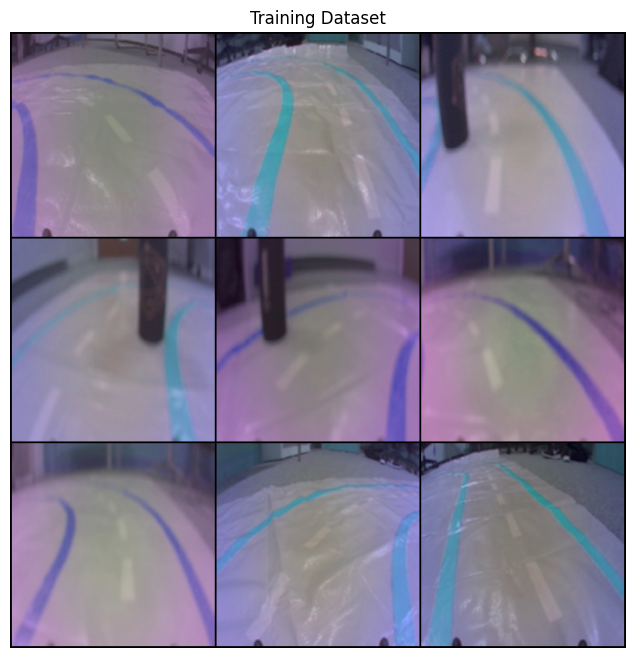

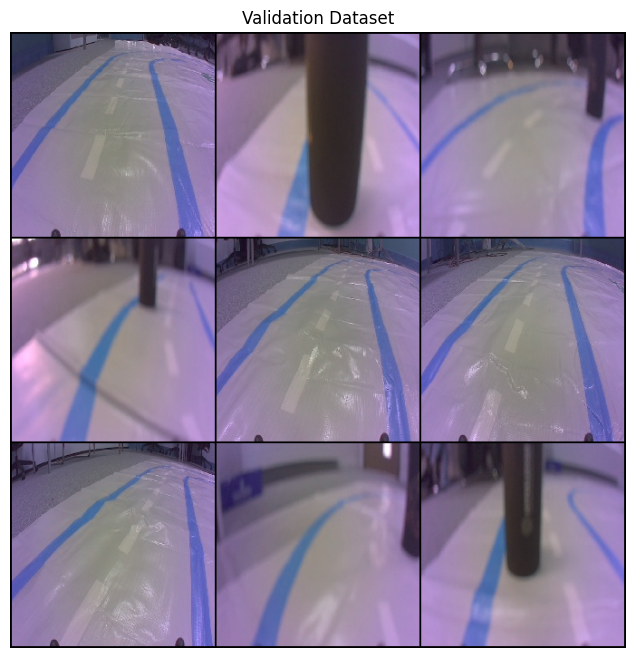

In [55]:
show_images(aug_train_dataloader, "Training Dataset")
show_images(aug_val_dataloader, "Validation Dataset")

We can now use our newly augmented data with our model. The best performing model was our simple CNN, so we will call the function to train and evaluate it.

In [56]:
model = CNN()
print(model)

train_model(model, aug_train_dataloader, aug_val_dataloader, NUM_EPOCHS, LEARNING_RATE, "Data Augmented - Simple CNN")

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Training Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▂▁▅
Training Loss,0.04418
Validation Loss,0.09423


Epoch [1/50], Loss: 84.9367
Epoch [2/50], Loss: 2.0804
Epoch [3/50], Loss: 1.2236
Epoch [4/50], Loss: 1.0578
Epoch [5/50], Loss: 1.1927
Epoch [6/50], Loss: 0.8090
Epoch [7/50], Loss: 0.7069
Epoch [8/50], Loss: 0.6418
Epoch [9/50], Loss: 0.5835
Epoch [10/50], Loss: 0.5758
Epoch [11/50], Loss: 0.5376
Epoch [12/50], Loss: 0.5894
Epoch [13/50], Loss: 0.4886
Epoch [14/50], Loss: 0.6452
Epoch [15/50], Loss: 0.5229
Epoch [16/50], Loss: 0.4267
Epoch [17/50], Loss: 0.4315
Epoch [18/50], Loss: 0.3997
Epoch [19/50], Loss: 0.5248
Epoch [20/50], Loss: 0.3993
Epoch [21/50], Loss: 0.5056
Epoch [22/50], Loss: 0.4139
Epoch [23/50], Loss: 0.4492
Epoch [24/50], Loss: 0.4029
Epoch [25/50], Loss: 0.3896
Epoch [26/50], Loss: 0.4053
Epoch [27/50], Loss: 0.3574
Epoch [28/50], Loss: 0.3637
Epoch [29/50], Loss: 0.3487
Epoch [30/50], Loss: 0.3220
Epoch [31/50], Loss: 0.3218
Epoch [32/50], Loss: 0.3204
Epoch [33/50], Loss: 0.3034
Epoch [34/50], Loss: 0.3135
Epoch [35/50], Loss: 0.4530
Epoch [36/50], Loss: 0.3633


Training Loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▂▂▁▁▁▂▁▂▂
Validation Loss,█▄▃▂▂▁▂▄▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▂▂▁▁▂▂▂▁▂▁▁▂▁
Training Loss,0.02001
Validation Loss,0.02494


### Task 5: Test Data Evaluation

We import our test dataset.

In [70]:
ROOT_DIR = './'
TASK = 'robo_racer_test'

In [71]:

test_dataset = XYDataset(ROOT_DIR + TASK, TRANSFORMS)

n_samples = len(test_dataset)

print(" Test Dataset length: ", n_samples)

 Test Dataset length:  298


We train and evaluate our simple CNN model with the validation taking place now on our test dataset

In [72]:
model = CNN()
print(model)

train_model(model, train_dataloader, test_dataset, NUM_EPOCHS, LEARNING_RATE, "Simple CNN - Test Evaluation")

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Epoch [1/50], Loss: 257.8061


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Loss: 1.8525
Epoch [3/50], Loss: 1.3288
Epoch [4/50], Loss: 1.0095
Epoch [5/50], Loss: 0.8499
Epoch [6/50], Loss: 0.7495
Epoch [7/50], Loss: 0.7422
Epoch [8/50], Loss: 0.5884
Epoch [9/50], Loss: 0.5269
Epoch [10/50], Loss: 0.5075
Epoch [11/50], Loss: 0.4537
Epoch [12/50], Loss: 0.4480
Epoch [13/50], Loss: 0.4501
Epoch [14/50], Loss: 0.5439
Epoch [15/50], Loss: 0.4151
Epoch [16/50], Loss: 0.3934
Epoch [17/50], Loss: 0.3894
Epoch [18/50], Loss: 0.3572
Epoch [19/50], Loss: 0.4482
Epoch [20/50], Loss: 0.3613
Epoch [21/50], Loss: 0.3386
Epoch [22/50], Loss: 0.3283
Epoch [23/50], Loss: 0.3197
Epoch [24/50], Loss: 0.3005
Epoch [25/50], Loss: 0.3126
Epoch [26/50], Loss: 0.2966
Epoch [27/50], Loss: 0.2800
Epoch [28/50], Loss: 0.2773
Epoch [29/50], Loss: 0.3718
Epoch [30/50], Loss: 0.2845
Epoch [31/50], Loss: 0.3388
Epoch [32/50], Loss: 0.3187
Epoch [33/50], Loss: 0.2871
Epoch [34/50], Loss: 0.2805
Epoch [35/50], Loss: 0.2949
Epoch [36/50], Loss: 0.2646
Epoch [37/50], Loss: 0.2493


Training Loss,▇█▇▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▂▁▂▂▂▂▁▂▂▂▂▁▂▂
Validation Loss,█▆▄▃▄▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▂▁▂▁▁▂▂▂
Training Loss,0.01076
Validation Loss,0.0296


We train and evaluate our simple CNN model with the validation taking place now on our test dataset

### Task 6: Reflection

Link to Weights and Biases report: https://api.wandb.ai/links/mlucd2024/fy3xoepu